# Multi-Task Learning for classification!

Here I am going to build a multi-output networks with PyTorch.<p>

In [1]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import glob
import os

# UTKFace Dataset
The dataset can be downloaded form the official website [here](https://susanqq.github.io/UTKFace/), however I have uploaded a copy of the "Aligned&Cropped Faces" to my personal google drive to make things easier. <p>

The following code will download the dataset and put it into within the data folder

In [2]:
import os
import zipfile

from pathlib import Path
import gdown

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.
    """
    # Setup path to data folder
    image_path = Path(f"data/{destination}") 
    output = f"data/{destination}.zip" 

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
    
    if not any(image_path.iterdir()):
        print("[INFO] Image folder is empty, download data from the drive...")
        gdown.download(source, output, quiet=False)

        # Unzip data
        with zipfile.ZipFile(output, "r") as zip_ref:
            print(f"[INFO] Unzipping {output} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(output)

    return image_path
    
source = "https://drive.google.com/uc?/export=download&id=1M8JM3978OkO4WPMGNavOm0qzstsTy-T8&confirm=t&uuid=40fc9c58-c062-4dca-89ad-9797dfa8b79d"
image_path = download_data(source=source,
                           destination="UTKFaces")
image_path

[INFO] data\UTKFaces directory exists, skipping download.


WindowsPath('data/UTKFaces')

# Data Exploration

The corresponding labels of an image can be interpreted from its name, such that: <p>
**[age] _ [gender] _ [race] _ [date&time].jpg**

In [3]:
images = []
ages = []
genders = []
races = []

for path in sorted(glob.glob((image_path / "*.jpg.chip.jpg").__str__())):
    filename = path.split("\\")[-1].split("_")
    if len(filename)==4:
        images.append(np.array(Image.open(path)))
        ages.append(int(filename[0]))
        genders.append(int(filename[1]))
        races.append(int(filename[2]))

print(len(images))

23704


In [4]:
dataset_dict = {
    'race_id': {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'},
    'gender_id': { 0: 'Male', 1: 'Female'}
}

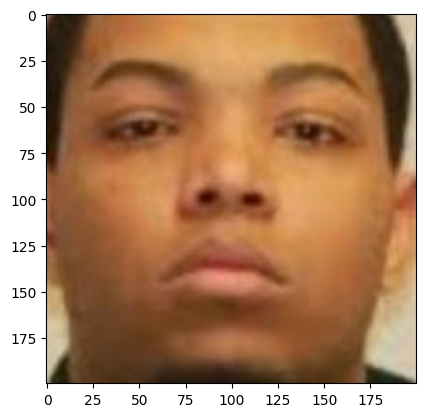

Age: 26
Gender: Male
Race: Black


In [5]:
idx = np.random.randint(len(images))

plt.imshow(images[idx])
plt.show()

print(f"Age: {ages[idx]}")
print(f"Gender: {dataset_dict['gender_id'][genders[idx]]}")
print(f"Race: {dataset_dict['race_id'][races[idx]]}")

Instead of modeling the age problem as a regression, here I convert it as a classification problem into age ranges. 


In [6]:
age_ranges = ['1-3', '4-7', '8-12', '13-19', '20-35', '36-55', '56-75', '76-116']
age_ranges_label = ['Baby', 'Child', 'Preteen', 'Teenager', 'Young Adult', 'Adult', 'Senior', 'Elderly']

df = pd.DataFrame(list(zip(age_ranges_label, age_ranges)),
               columns =['Label', 'Age range'])
df

,Label,Age range
0,Baby,1-3
1,Child,4-7
2,Preteen,8-12
3,Teenager,13-19
4,Young Adult,20-35
5,Adult,36-55
6,Senior,56-75
7,Elderly,76-116


In [7]:
dataset_dict = {
    'race_id': {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'},
    'gender_id': { 0: 'Male', 1: 'Female'},
    'age_id': {0: 'Baby', 1: 'Child', 2: 'Preteen', 3: 'Teenager', 4: 'Young adult', 5: 'Adult', 6: 'Senior', 7: 'Elderly'},
}

In [8]:
# Define the labels and corresponding age ranges
new_ranges = ['1-3', '4-7', '8-12', '13-19', '20-35', '36-55', '56-75', '76-116']
new_labels = list(range(len(new_ranges)))

# Create a function to categorize an age
def categorize_age(age):
    for i, age_range in enumerate(new_ranges):
        start, end = map(int, age_range.split('-'))
        if start <= age <= end:
            return new_labels[i]
    return None  # Return None for ages that don't fall into any range

# Categorize the ages
age_classes = [categorize_age(age) for age in ages]

# # Print the results
# for age, category in zip(ages, age_classes):
#     print(f"Age: {age}, Category: {category}")

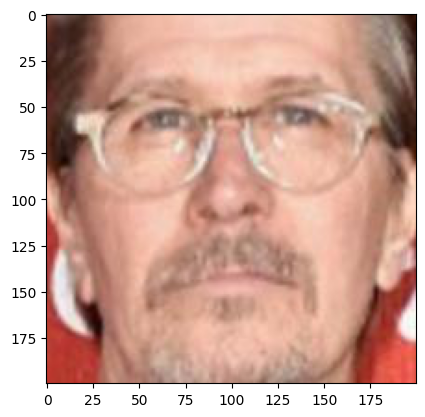

Age: Senior (56-75)
Gender: Male
Race: White


In [9]:
idx = np.random.randint(len(images))

plt.imshow(images[idx])
plt.show()

print(f"Age: {dataset_dict['age_id'][age_classes[idx]]} ({new_ranges[age_classes[idx]]})")
print(f"Gender: {dataset_dict['gender_id'][genders[idx]]}")
print(f"Race: {dataset_dict['race_id'][races[idx]]}")

Next, some analysis on the dataset and distributions within the dataset for age, gender and race.

In [10]:
import seaborn as sns
import pandas as pd

d = {'age': ages, 'gender': genders, 'race': races, 'age_classes': age_classes}
df = pd.DataFrame(data=d)
df

,age,gender,race,age_classes
0,100,0,0,7
1,100,0,0,7
2,100,1,0,7
3,100,1,0,7
4,100,1,0,7
...,...,...,...,...
23699,9,1,3,2
23700,9,1,3,2
23701,9,1,4,2
23702,9,1,4,2


c:\Users\elnas\anaconda3\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elnas\anaconda3\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\elnas\anaconda3\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elnas\anaconda3\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

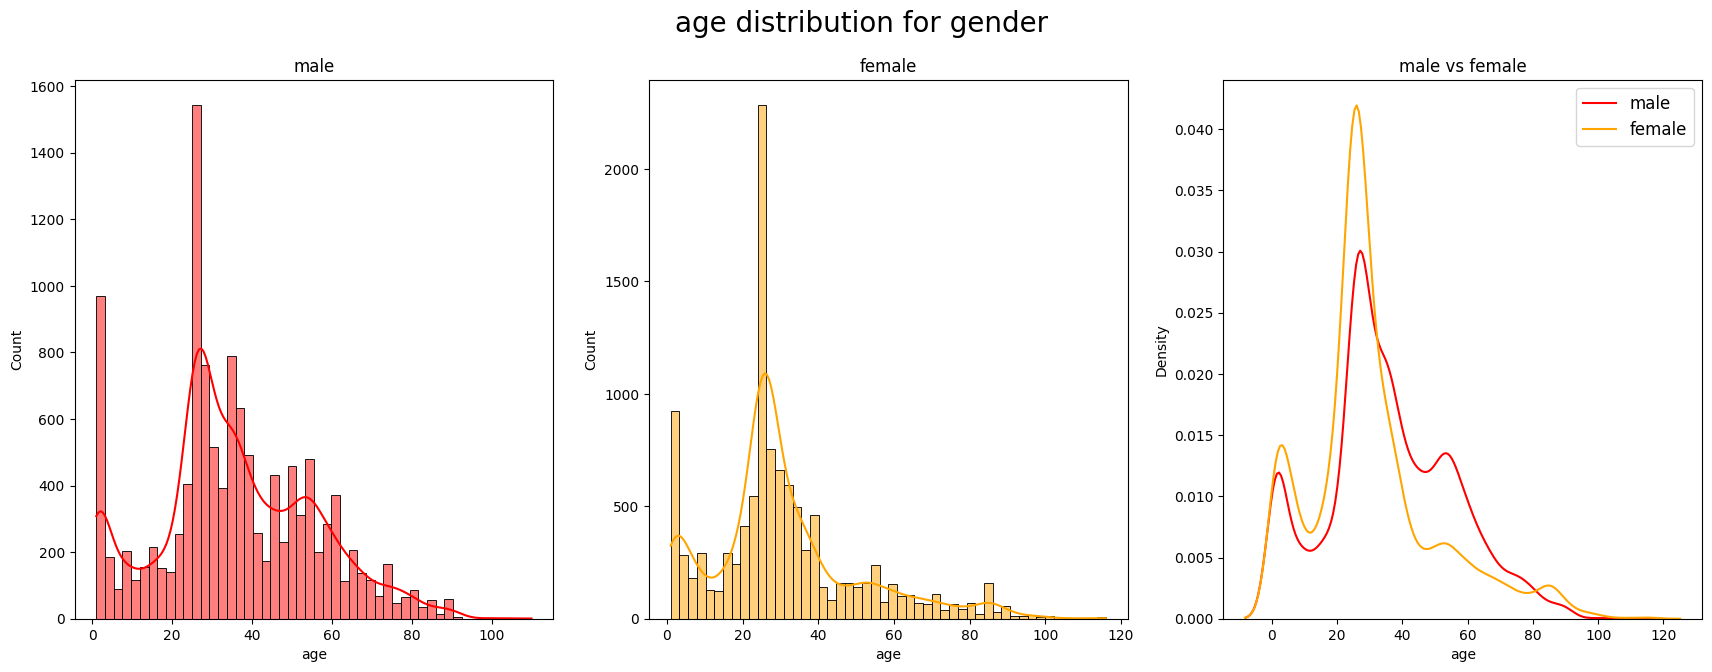

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('age distribution for gender', fontsize=20)

df_age_male = df.groupby('gender').get_group(0)
df_age_female = df.groupby('gender').get_group(1)
sns.histplot(data=df_age_male, x="age", kde=True, color="red", ax=ax1, bins=50)
sns.histplot(data=df_age_female, x="age", kde=True, color="orange", ax=ax2, bins=50)
ax1.title.set_text("male")
ax2.title.set_text("female")


sns.kdeplot(data=df_age_male, x="age", color="red", ax=ax3)
sns.kdeplot(data=df_age_female, x="age", color="orange", ax=ax3)
ax3.legend(["male", "female"], fontsize="large")
ax3.title.set_text("male vs female")

plt.show()

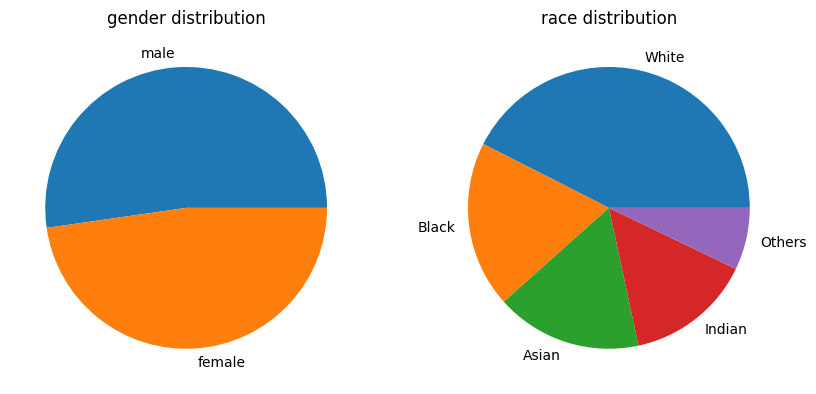

In [12]:
pie, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,6])
df.gender.value_counts().plot(kind='pie', labels=["male", "female"], pctdistance=0.5, ax = ax1)
ax1.yaxis.set_visible(False)
ax1.title.set_text('gender distribution')

df.race.value_counts().plot(kind='pie', labels=["White", "Black", "Asian", "Indian", "Others"], pctdistance=0.5, ax = ax2)
ax2.yaxis.set_visible(False)
ax2.title.set_text('race distribution')

plt.show()

c:\Users\elnas\anaconda3\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elnas\anaconda3\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\elnas\anaconda3\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elnas\anaconda3\envs\myenv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

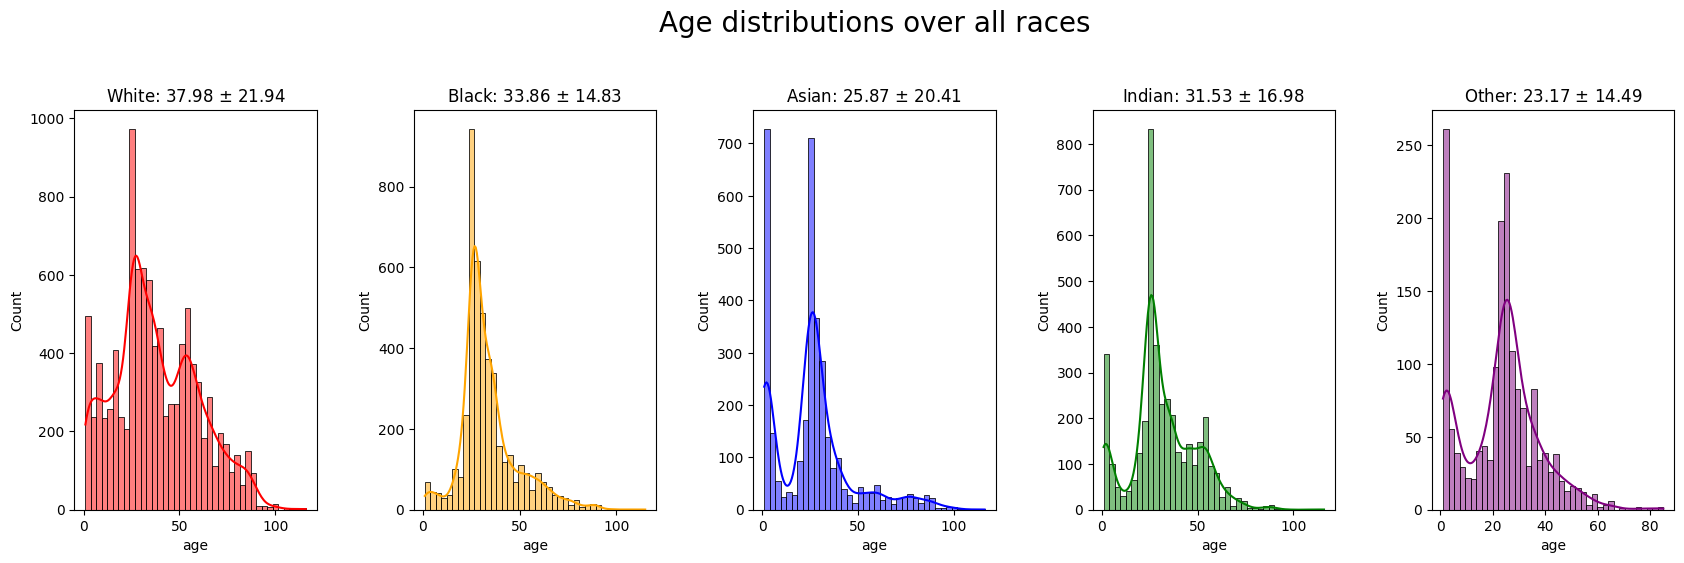

In [13]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Age distributions over all races', fontsize=20, y=1.1)
fig.tight_layout()

df_race_white = df.groupby('race').get_group(0)
sns.histplot(data=df_race_white, x="age", kde=True, color="red", ax=ax1, bins=40)
ax1.title.set_text(f"White: {np.round(df_race_white.mean()['age'], 2)} $\pm$ {np.round(df_race_white.std()['age'], 2)}")

df_race_black = df.groupby('race').get_group(1)
sns.histplot(data=df_race_black, x="age", kde=True, color="orange", ax=ax2, bins=40)
ax2.title.set_text(f"Black: {np.round(df_race_black.mean()['age'], 2)} $\pm$ {np.round(df_race_black.std()['age'], 2)}")

df_race_asian = df.groupby('race').get_group(2)
sns.histplot(data=df_race_asian, x="age", kde=True, color="blue", ax=ax3, bins=40)
ax3.title.set_text("asian")
ax3.title.set_text(f"Asian: {np.round(df_race_asian.mean()['age'], 2)} $\pm$ {np.round(df_race_asian.std()['age'], 2)}")

df_race_indian = df.groupby('race').get_group(3)
sns.histplot(data=df_race_indian, x="age", kde=True, color="green", ax=ax4, bins=40)
ax4.title.set_text(f"Indian: {np.round(df_race_indian.mean()['age'], 2)} $\pm$ {np.round(df_race_indian.std()['age'], 2)}")

df_race_other = df.groupby('race').get_group(4)
sns.histplot(data=df_race_other, x="age", kde=True, color="purple", ax=ax5, bins=40)
ax5.title.set_text(f"Other: {np.round(df_race_other.mean()['age'], 2)} $\pm$ {np.round(df_race_other.std()['age'], 2)}")

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.show()

# Create a custom Dataset with PyTorch

In [14]:
# Create a function to categorize an age
def categorize_age(age):
    for i, age_range in enumerate(new_ranges):
        start, end = map(int, age_range.split('-'))
        if start <= age <= end:
            return new_labels[i]
    return None  # Return None for ages that don't fall into any range

In [15]:
class UTKFace(Dataset):
    def __init__(self, image_paths):
        # Define the Transforms
        self.transform = transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.5),
            transforms.RandomVerticalFlip(),
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])


        # Set Inputs and Labels
        self.image_paths = image_paths
        self.images = []
        self.ages = []
        self.genders = []
        self.races = []

        for path in image_paths:
            filename = path.split("\\")[-1].split("_")
            if len(filename)==4:
                self.images.append(path)
                self.ages.append(categorize_age(int(filename[0])))
                self.genders.append(int(filename[1]))
                self.races.append(int(filename[2]))

    def __len__(self):
         return len(self.images)

    def __getitem__(self, index):
        # Load an Image
        img = Image.open(self.images[index]).convert('RGB')
        
        # Transform it
        img = self.transform(img)

        # Get the Labels
        age = self.ages[index]
        gender = self.genders[index]
        race = self.races[index]

        return {'image':img, 'age': age, 'gender': gender, 'race':race}

## Train/Test Split

In [16]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [17]:
# define the train and val splits
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.3

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
image_paths = sorted(glob.glob((image_path / "*.jpg.chip.jpg").__str__()))

num_train = round(TRAIN_SPLIT*len(image_paths))
num_val = round(VAL_SPLIT*len(image_paths))

print('No of train samples', num_train)
print('No of validation Samples', num_val)

No of train samples 16595
No of validation Samples 7112


In [19]:
(train_data, valid_data) = random_split(image_paths,[num_train, num_val], generator=torch.Generator().manual_seed(42))

## Dataloader

In [20]:
BATCH_SIZE = 1024

train_dataset = UTKFace(train_data)
valid_dataset = UTKFace(valid_data)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(valid_dataset, shuffle=False, batch_size=BATCH_SIZE)

train_steps = len(train_dataloader.dataset) // BATCH_SIZE
val_steps = len(val_dataloader.dataset) // BATCH_SIZE

In [21]:
def imshow(img):
    # Unnormalize
    img = img / 2 + 0.5
	# convert to Numpy
    npimg = img.numpy()
	# Transpose to get the correct color
    npimg=np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


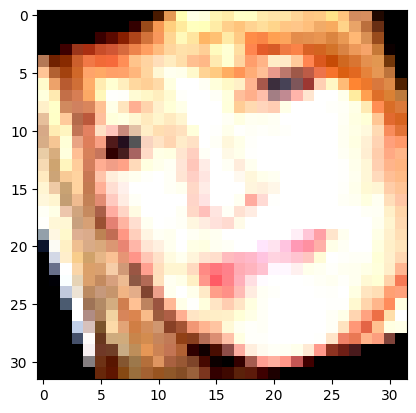

5
Adult (36-55)
Female
White


In [22]:
sample = next(iter(train_dataloader))

imshow(sample['image'][0])

print(sample["age"][0].item())
print(f"{dataset_dict['age_id'][sample['age'][0].item()]} ({new_ranges[sample['age'][0].item()]})")
print(dataset_dict['gender_id'][sample["gender"][0].item()])
print(dataset_dict['race_id'][sample["race"][0].item()])

# Multi-Task Neural Network with PyTorch

### Define the HydraNet class and Base Model

In [23]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, resnet34, resnet50, resnet101

In [24]:
from collections import OrderedDict

In [25]:
class HydraNetModified(nn.Module):
    def __init__(self, net):
        super(HydraNetModified, self).__init__()
        self.net = net
        self.n_features = self.net.fc.in_features
        self.net.fc = nn.Identity()
        self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 8))]))
        self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 1))]))
        self.net.fc3 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 5))]))

    def forward(self, x):
        age_head = self.net.fc1(self.net(x))
        gender_head = self.net.fc2(self.net(x))
        race_head = self.net.fc3(self.net(x))
        return age_head, gender_head, race_head

In [26]:
net = resnet34(pretrained=True)
model = HydraNetModified(net)
model.to(device=device)

loss_fn_1 = nn.CrossEntropyLoss() 
loss_fn_2 = nn.BCELoss() 
loss_fn_3 = nn.CrossEntropyLoss() 

lr = 3e-3
momentum = 0.09 # Meaning that we will go 9% with the previous direction
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

c:\Users\elnas\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\elnas\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train the Model

In [27]:
from sklearn.metrics import mean_absolute_error as mae

n_epochs = 50

logger = {"train_loss": [],
          "validation_loss": [],
          "train_gender_loss": [],
          "train_race_loss": [],
          "train_age_loss": [],
          "validation_gender_loss": [],
          "validation_race_loss": [],
          "validation_age_loss": []
          }

In [28]:
sig = nn.Sigmoid()

for epoch in range(n_epochs):
    model.train()

    total_training_loss = 0
    total_validation_loss = 0
    training_gender_loss = 0
    training_race_loss = 0
    training_age_loss = 0
    validation_gender_loss = 0
    validation_race_loss = 0
    validation_age_loss = 0

    for data in train_dataloader:
        inputs = data["image"].to(device=device)
        # age_label = dataset_dict['age_id'][data["age"].to(device=device)]
        age_label = data["age"].to(device=device)

        gender_label = data["gender"].to(device=device)
        race_label = data["race"].to(device=device)

        optimizer.zero_grad()
        age_output, gender_output, race_output = model(inputs)

        loss_1 = loss_fn_1(race_output, race_label)
        loss_2 = loss_fn_2(gender_output, gender_label.unsqueeze(1).float())
        loss_3 = loss_fn_3(age_output, age_label)

        loss = loss_1 + loss_2 + loss_3

        loss.backward()
        optimizer.step()
        total_training_loss += loss

        training_race_loss += loss_1.item()
        training_gender_loss += loss_2.item()
        training_age_loss += loss_3.item()
    print('EPOCH ', epoch+1)
    print(f"Training Losses: Race: {loss_1}, Gender: {loss_2}, Age: {loss_3}")

    with torch.no_grad():
        model.eval()

        for data in val_dataloader:
            inputs = data["image"].to(device=device)
            age_label = data["age"].to(device=device)
            gender_label = data["gender"].to(device=device)
            race_label =  data["race"].to(device=device)
            age_output, gender_output, race_output = model(inputs)

            loss_1 = loss_fn_1(race_output, race_label)
            loss_2 = loss_fn_2(gender_output, gender_label.unsqueeze(1).float())
            loss_3 = loss_fn_3(age_output, age_label)

            loss = loss_1 + loss_2 + loss_3
            total_validation_loss += loss

            validation_race_loss += loss_1.item()
            validation_gender_loss += loss_2.item()
            validation_age_loss += loss_3.item()
        print(f"Validation Losses: Race: {loss_1}, Gender: {loss_2}, Age: {loss_3}")

    avgTrainLoss = total_training_loss / train_steps
    avgValLoss = total_validation_loss / val_steps

    print(f'Average Losses — Training: {avgTrainLoss} | Validation {avgValLoss}')
    print()
    avgTrainGenderLoss = training_gender_loss/len(train_dataloader.dataset)
    avgTrainRaceLoss = training_race_loss/len(train_dataloader.dataset)
    avgTrainAgeLoss = training_age_loss/len(train_dataloader.dataset)

    avgValGenderLoss = validation_gender_loss/len(val_dataloader.dataset)
    avgValRaceLoss = validation_race_loss/len(val_dataloader.dataset)
    avgValAgeLoss = validation_age_loss/len(val_dataloader.dataset)

    logger["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    logger["train_gender_loss"].append(avgTrainGenderLoss)
    logger["train_race_loss"].append(avgTrainRaceLoss)
    logger["train_age_loss"].append(avgTrainAgeLoss)

    logger["validation_loss"].append(avgValLoss.cpu().detach().numpy())
    logger["validation_gender_loss"].append(avgValGenderLoss)
    logger["validation_race_loss"].append(avgValRaceLoss)
    logger["validation_age_loss"].append(avgValAgeLoss)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
torch.save(model.state_dict(), "best_model.pth")

## Results

In [ ]:
plt.plot(logger["train_loss"])
plt.plot(logger["validation_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(logger["train_gender_loss"])
plt.plot(logger["validation_gender_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(logger["train_race_loss"])
plt.plot(logger["validation_race_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(logger["train_age_loss"])
plt.plot(logger["validation_age_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Inference

In [ ]:
indexes = valid_data.indices
test_indices = random.sample(indexes, 10)
test_indices

In [ ]:
for idx in test_indices:
    plt.figure()
    plt.imshow(images[idx])
    plt.show()

    image_norm = images[idx] / 255.0
    image_norm = (torch.from_numpy(image_norm).view(1, 3, image_norm.shape[0], image_norm.shape[1]).float())

    model.eval()
    age, gender, race = model(image_norm.to(device=device))

    predicted_age = int(age.argmax(dim=1))

    print(f"Age: {ages[idx]} | Predicted: {predicted_age} ({new_ranges[predicted_age]})")

    sigmoid = nn.Sigmoid()
    out_gender = int(torch.round(sigmoid(gender)).item())
    gender_classes = ["male", "female"]
    # print("Gender:", str(dataset_dict['gender_id'][genders[idx]]), "| Predicted:", str(gender_classes[out_gender]))
    print(f"Gender: {dataset_dict['gender_id'][genders[idx]]} | Predicted: {gender_classes[out_gender]}")

    out_race = torch.argmax(F.softmax(race, dim=1)).item()
    race_classes = ["white", "black", "asian", "indian", "other"]
    # print("Race:", str(dataset_dict['race_id'][races[idx]]), "| Predicted:", str(race_classes[out_race]))
    print(f"Race: {dataset_dict['race_id'][races[idx]]} | Predicted: {race_classes[out_race]}")

    print('\n')